In [2]:
from Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from BaggingGA import BaggingGA
from BaggingSA import BaggingSA

In [6]:
seed = 42
np.random.seed(seed)
random.seed(seed)
data = datasets.load_digits()


X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [7]:
def fun_monitor_ga(iteration, best_fitness, cur_fitness, accuracy):
    print(f"Iteration: {iteration}, Best fitness: {best_fitness:.3f}, Current fitness: {cur_fitness:.3f}, Accuracy: {accuracy:.3f}")

def evaluate_bagging_ga(n_trees):
    bagging_sga = BaggingGA(X=X_train, y=y_train,
                                    n_trees=n_trees, max_iterations=200,  
                                    mutation_rate=0.01, generation_gap=0.5, population_size=100)
    models = bagging_sga.run(X_for_test=X_test, y_for_test=y_test, fun_monitor=fun_monitor_ga)
    accuracy = evaluate(X_test, y_test, models=models)
    return accuracy


def evaluate_bagging(n_trees):
    bags = create_bags(X_train, n_trees)
    models = create_models(X=X_train, y=y_train, bags=bags)
    accuracy = evaluate(X_test, y_test, models=models)
    return accuracy

def evaluate_bagging_sa(n_trees):
    bagging_sa = BaggingSA(X=X_train, y=y_train,
                            T0=10, cooling_method='geometric', alpha=0.98, max_iterations=2000, n_trees=n_trees,
                            feature_mutation_chance=0.4, test_split_amount=10)
    models = bagging_sa.run(X_for_test=X_test, y_for_test=y_test, monitor_fun=fun_monitor_sa)
    accuracy = evaluate(X_test, y_test, models=models)
    return accuracy
    

def fun_monitor_sa(iteration, T, best_fitness, fitness, new_fitness, accuracy):
    print(f"I: {iteration}, T: {T:.3f}, Best fitness: {best_fitness:.3f}, Fitness: {fitness:.3f}, New fitness: {new_fitness:.3f}, Accuracy: {accuracy:.3f}")

def evaluate_decision_tree():
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [8]:
n_trees = [5, 10, 15, 20, 25]
reps = 5

results = []

for n in n_trees:
    for r in range(reps):
        dt_mean = evaluate_decision_tree()
        bagging_mean  = evaluate_bagging(n)
        bagging_ga_mean = evaluate_bagging_ga(n)
        bagging_sa_mean = evaluate_bagging_sa(n)
        
        results.append({
            'TreesAmount': n,
            'DecisionTree': dt_mean,
            'Bagging': bagging_mean,
            'BaggingGA': bagging_ga_mean,
            'BaggingSA': bagging_sa_mean,
        })
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'./../res/bagging_multiple_results.csv', index=False)
        
print(results_df)

Iteration: 0, Best fitness: 0.542, Current fitness: 0.542, Accuracy: 0.853
Iteration: 1, Best fitness: 0.549, Current fitness: 0.549, Accuracy: 0.844
Iteration: 2, Best fitness: 0.549, Current fitness: 0.549, Accuracy: 0.800
Iteration: 3, Best fitness: 0.549, Current fitness: 0.514, Accuracy: 0.828
Iteration: 4, Best fitness: 0.549, Current fitness: 0.535, Accuracy: 0.833
Iteration: 5, Best fitness: 0.549, Current fitness: 0.535, Accuracy: 0.806
Iteration: 6, Best fitness: 0.549, Current fitness: 0.549, Accuracy: 0.844
Iteration: 7, Best fitness: 0.549, Current fitness: 0.535, Accuracy: 0.817
Iteration: 8, Best fitness: 0.549, Current fitness: 0.524, Accuracy: 0.825
Iteration: 9, Best fitness: 0.549, Current fitness: 0.531, Accuracy: 0.847
Iteration: 10, Best fitness: 0.549, Current fitness: 0.538, Accuracy: 0.833
Iteration: 11, Best fitness: 0.549, Current fitness: 0.542, Accuracy: 0.814
Iteration: 12, Best fitness: 0.549, Current fitness: 0.545, Accuracy: 0.786
Iteration: 13, Best fi

In [9]:
from tabulate import tabulate
df = pd.read_csv('./../res/bagging_multiple_results.csv')

result_df_aggregated = df.groupby('TreesAmount').agg(
    DecisionTreeMean=('DecisionTree', 'mean'),
    DecisionTreeStd=('DecisionTree', 'std'),
    BaggingMean=('Bagging', 'mean'),
    BaggingStd=('Bagging', 'std'),
    BaggingSAMean=('BaggingSA', 'mean'),
    BaggingSAStd=('BaggingSA', 'std'),
    BaggingGAMean=('BaggingGA', 'mean'),
    BaggingGAStd=('BaggingGA', 'std')
).reset_index()

result_df_aggregated.to_csv('./../res/bagging_multiple_results_aggregated.csv', index=False)

tmp = result_df_aggregated.copy().round(3)
print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))


+-------------+------------------+-----------------+-------------+------------+---------------+--------------+---------------+--------------+
| TreesAmount | DecisionTreeMean | DecisionTreeStd | BaggingMean | BaggingStd | BaggingSAMean | BaggingSAStd | BaggingGAMean | BaggingGAStd |
+-------------+------------------+-----------------+-------------+------------+---------------+--------------+---------------+--------------+
|     5.0     |      0.854       |      0.003      |    0.769    |   0.024    |     0.814     |    0.022     |     0.841     |    0.024     |
|    10.0     |      0.856       |      0.004      |    0.851    |   0.025    |     0.899     |    0.022     |     0.904     |    0.011     |
|    15.0     |      0.854       |      0.011      |    0.887    |   0.011    |     0.926     |    0.012     |     0.928     |    0.014     |
|    20.0     |      0.846       |      0.01       |    0.907    |   0.013    |     0.921     |    0.009     |     0.928     |    0.007     |
|    2

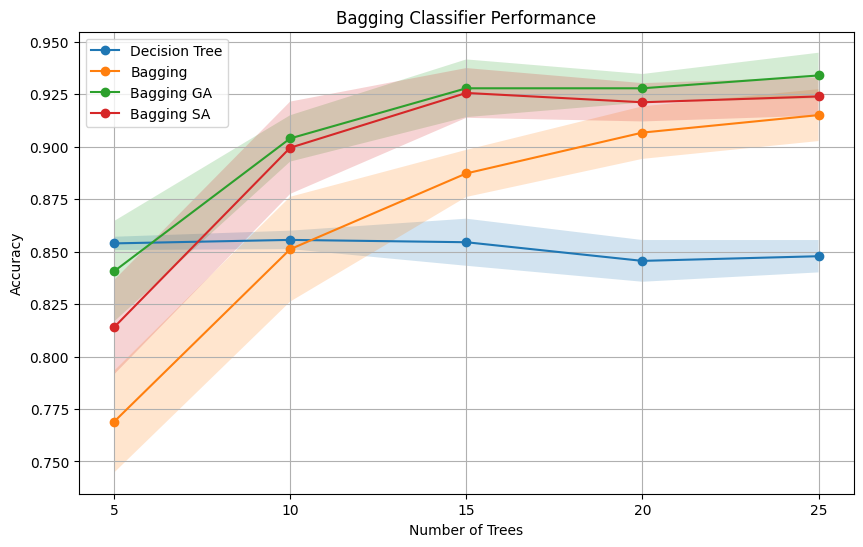

In [3]:
import matplotlib.pyplot as plt

results_df = pd.read_csv(f'./../res/bagging_multiple_results_aggregated.csv')

plt.figure(figsize=(10, 6))

X = results_df['TreesAmount']
dt_mean = results_df['DecisionTreeMean']
dt_std = results_df['DecisionTreeStd']
bagging_ga_mean = results_df['BaggingGAMean']
bagging_ga_std = results_df['BaggingGAStd']
bagging_mean = results_df['BaggingMean']
bagging_std = results_df['BaggingStd']
bagging_sa_mean = results_df['BaggingSAMean']
bagging_sa_std = results_df['BaggingSAStd']

plt.plot(X, dt_mean, marker='o', label='Decision Tree')
plt.fill_between(X, dt_mean - dt_std, dt_mean + dt_std, alpha=0.2)

plt.plot(X, bagging_mean, marker='o', label='Bagging')
plt.fill_between(X, bagging_mean - bagging_std, bagging_mean + bagging_std, alpha=0.2)


plt.plot(X, bagging_ga_mean, marker='o', label='Bagging GA')
plt.fill_between(X, bagging_ga_mean - bagging_ga_std, bagging_ga_mean + bagging_ga_std, alpha=0.2)

plt.plot(X, bagging_sa_mean, marker='o', label='Bagging SA')
plt.fill_between(X, bagging_sa_mean - bagging_sa_std, bagging_sa_mean + bagging_sa_std, alpha=0.2)

plt.title('Bagging Classifier Performance')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(X)
plt.grid()
plt.savefig('./../res/bagging_multiple_results.png')